In [1]:
import os

from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import wave

In [2]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1, desired_samples=48000)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [10]:
file = r"C:\dumi\bird_reco\sounds\recordings\sound_.wav"



In [3]:
house_sparrows_dir = os.path.join('..', 'sounds', 'House Sparrow', 'splits')
common_buzzard_dir = os.path.join('..', 'sounds', 'Common Buzzard', 'splits')


for file in os.listdir(common_buzzard_dir):
    sample_width = 0
    with wave.open(os.path.join(f'{common_buzzard_dir}', file), "rb") as wave_file:
        getparams = wave_file.getparams()
        sample_width = getparams.sampwidth
    if sample_width != 2:
        os.remove(os.path.join(f'{common_buzzard_dir}', file))

for file in os.listdir(house_sparrows_dir):
    sample_width = 0
    with wave.open(os.path.join(f'{house_sparrows_dir}', file), "rb") as wave_file:
        getparams = wave_file.getparams()
        sample_width = getparams.sampwidth
    if sample_width != 2:
        os.remove(os.path.join(f'{house_sparrows_dir}', file))


house_sparrows = tf.data.Dataset.list_files(house_sparrows_dir + "\*.wav").take(32)
common_buzzard = tf.data.Dataset.list_files(common_buzzard_dir + "\*.wav").take(32)



In [4]:

sparrows = tf.data.Dataset.zip((house_sparrows, tf.data.Dataset.from_tensor_slices(tf.ones(len(house_sparrows)))))
buzzards = tf.data.Dataset.zip((house_sparrows, tf.data.Dataset.from_tensor_slices(tf.zeros(len(common_buzzard)))))
data = sparrows.concatenate(buzzards)

In [5]:
sparrows.as_numpy_iterator().next()
len(sparrows)

32

In [7]:
lengths = []
skipped = 0
count = 0
for file in os.listdir(house_sparrows_dir):
    count += 1 
    if count >=32 :
        break
    try:
        tensor_wave = load_wav_16k_mono(os.path.join(house_sparrows_dir, file))
        lengths.append(len(tensor_wave))
    except Exception as e:
        skipped += 1
        print(file)
        pass
print("done")

done


In [8]:
lengths

[17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414,
 17414]

In [9]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=17414>

In [10]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label
    

In [11]:

filepath, label = sparrows.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)
label

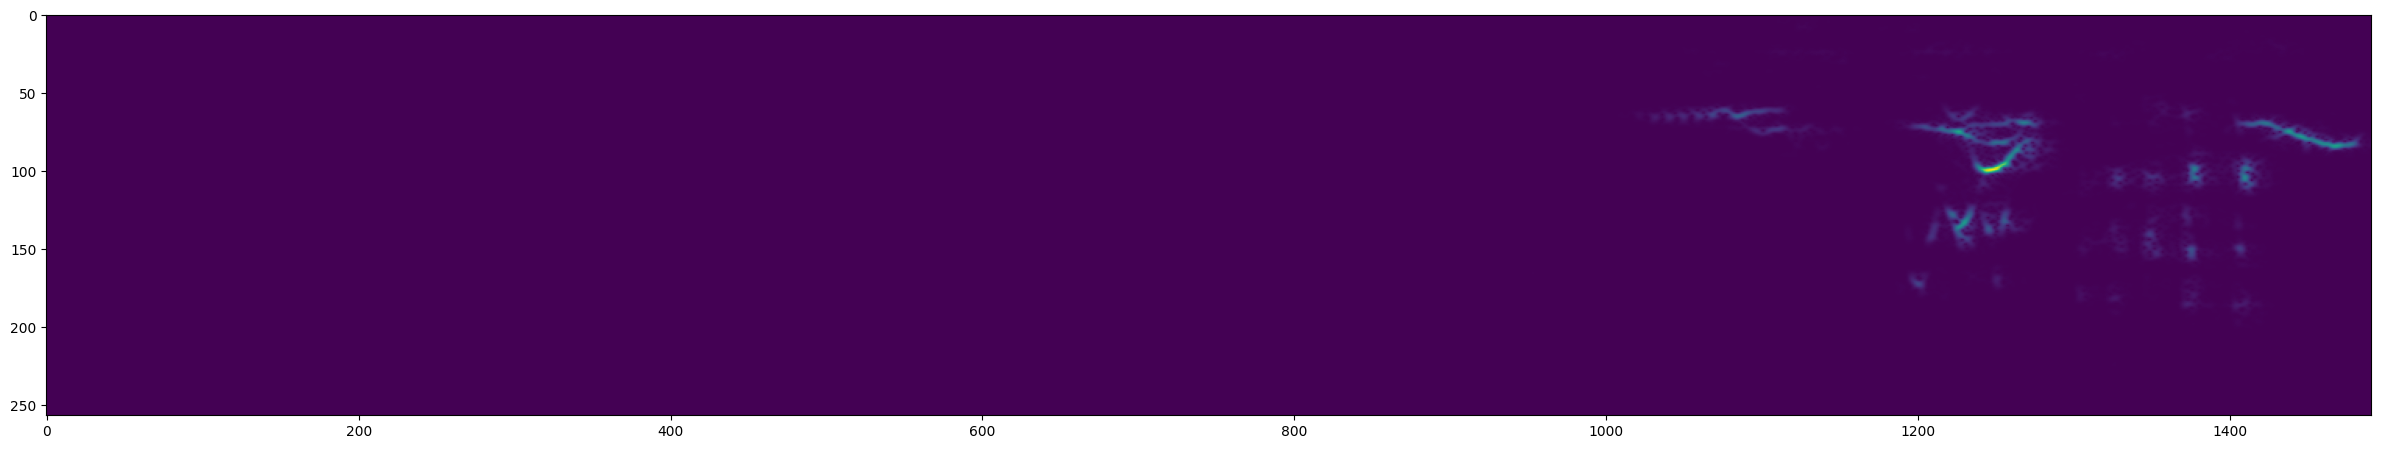

In [13]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()


In [14]:
data = sparrows.map(preprocess)
data = data.cache(filename="tmp/cache")
data = data.shuffle(buffer_size=16)
data = data.batch(1)
data = data.prefetch(1)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [15]:
import time 
def benchmark(dataset, num_epochs=2):
    for epoch_num in range(num_epochs):
        for sample in dataset:
            time.sleep(0.01)

In [43]:
%%timeit -n1 -r1
benchmark(data, 5)

2min 54s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [16]:
train = data.take(36)
test = data.skip(36).take(15)


In [17]:
samples, labels = train.as_numpy_iterator().next()

In [18]:
samples.shape

(1, 1491, 257, 1)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [20]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation="relu", input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation="relu"))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [22]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [23]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [1]:
hist = model.fit(train, epochs=2)


NameError: name 'model' is not defined

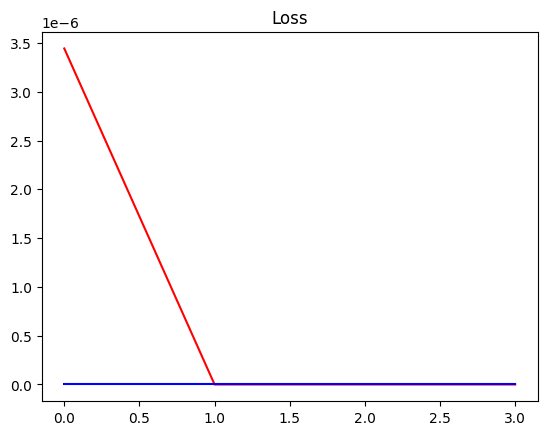

In [133]:

plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

KeyError: 'precision'

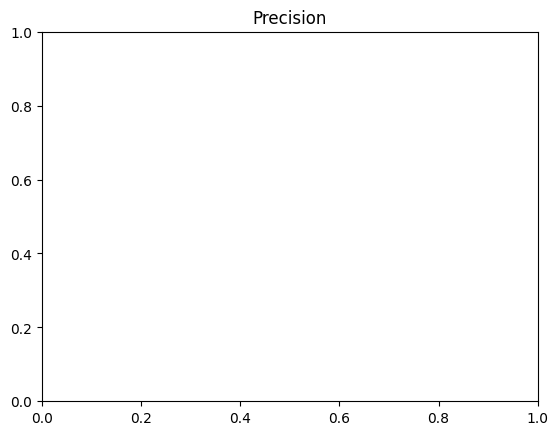

In [134]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

KeyError: 'recall'

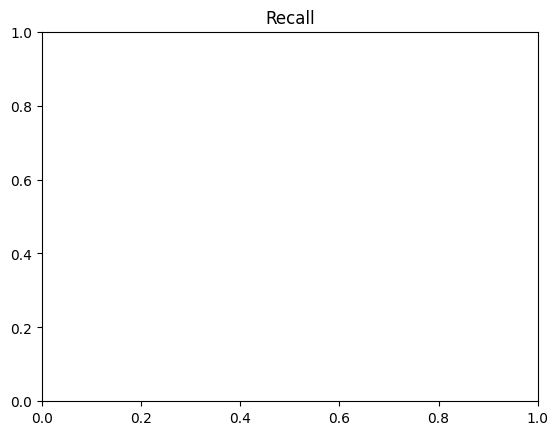

In [135]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [136]:
X_test, y_test = test.as_numpy_iterator().next()


In [137]:
print(X_test)
yhat = model.predict(X_test)


[[[[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  ...

  [[8.91138334e-05]
   [9.08486472e-05]
   [1.22356607e-04]
   ...
   [3.49177003e-06]
   [2.28642602e-06]
   [4.88944352e-09]]

  [[9.16891731e-05]
   [8.31191865e-05]
   [1.17975993e-04]
   ...
   [4.73765340e-06]
   [1.95849839e-06]
   [1.91619620e-06]]

  [[1.01963989e-04]
   [5.89099982e-05]
   [8.10053898e-05]
   ...
   [5.81873064e-06]
   [3.26017016e-06]
   [1.74622983e-06]]]


 [[[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
 

In [138]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]


In [139]:
yhat

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [140]:

def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1)/2
    
    sample_rate = res.rate 
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=160000)
    return wav


In [141]:
wav_file = r"C:\dumi\bird_reco\sounds\recordings\sound_.wav"

In [142]:
wav = load_mp3_16k_mono(wav_file)

In [143]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)


In [144]:
samples, index = audio_slices.as_numpy_iterator().next()


In [145]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [146]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [147]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

1/1 [==============================] - 3s 3s/step


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [148]:
from itertools import groupby


In [149]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
yhat


[1]

In [150]:
calls


1

In [151]:
results = {}
for file in os.listdir(os.path.join('..', 'sounds', 'recordings')):
    FILEPATH = os.path.join('..', 'sounds', 'recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 3s 3s/step


In [152]:
results


{'sound_.wav': array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=float32)}

In [153]:
class_preds = {}
print(results.items())
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.5 else 0 for prediction in logits]
    


dict_items([('sound_.wav', array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32))])


In [154]:
len(class_preds['sound_.wav'])

53

In [155]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'sound_.wav': 1}

In [156]:
import csv


In [157]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'house_sparrow_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])